In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [3]:
from loadRIPA import *
df = loadRIPA()
df['year-month'] = pd.to_datetime(df.date_stop, format='%Y-%m-%d').dt.strftime("%Y-%m")

In [3]:
# create a temporary dataframe to check the frequency of top 15 penal code in the stop reason
reason_df = df.groupby(['reason_for_stop_code_text'], as_index=False).size()
reason_df = reason_df.sort_values(['size'], ascending=False).reset_index(drop=True)
reason_df[:20]

,reason_for_stop_code_text,size
0,65002 ZZ - LOCAL ORDINANCE VIOL (I) 65002,52416
1,602 PC - TRESPASSING (M) 32022,37867
2,22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167,34040
3,647(E) PC - DIS CON:LODGE W/O CONSENT (M) 32111,32319
4,22350 VC - UNSAFE SPEED:PREVAIL COND (I) 54106,32098
5,4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) 54657,30952
6,65000 ZZ - LOCAL ORDINANCE VIOL (M) 65000,26551
7,NA - XX ZZ - COMMUNITY CARETAKING (X) 99990,22749
8,5200(A) VC - DISPLAY LIC PLATES WRONG (I) 54644,22037
9,647(F) PC - DISORD CONDUCT:ALCOHOL (M) 64005,17146


In [4]:
# 5&18 can go together; 2&10
4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) 54657
5204(A) VC - EXPIRED TABS/FAIL DISPLAY (I) 54168

22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167
21461(A) VC - DRIVER FAIL OBEY SIGN/ETC (I) 54146

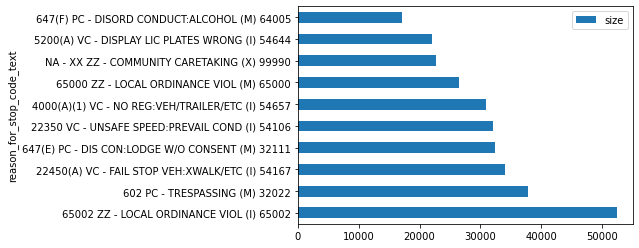

In [5]:
# sample plot of the 10 most common reason 
temp = reason_df.head(10)
temp.plot.barh(x="reason_for_stop_code_text", y=["size"])
plt.show()

#### Outcome Test

We are going to explore whether or not there exists a racial disparity in some of the common stop violations, such as speeding, public intoxication, community caretaking, along with homeless-related stops by using the outcome test to see which violation expresses an unusual result.

In [7]:
# First, we categorized each stop outcome into 3 groups: arrested, citation, and warning
trans = {'Citation for infraction':'Citation', 'In-field cite and release':'Citation', 
         'Custodial Arrest without warrant':'Arrested', 'Contacted U.S. Department of Homeland Security':'Arrested',
         'Psychiatric hold':'Psychiatric Hold', 'Custodial Arrest pursuant to outstanding warrant':'Arrested', 
         'Warning (verbal or written)':'Warning', 'Field interview card completed':'No Action', 'No Action':'No Action',
         'Noncriminal transport or caretaking transport':'Transported',  
         'Contacted parent/legal guardian or other person responsible for the minor':'Parents Contacted',
         'Referral to school administrator':'Referred to school', 
         'Referral to school counselor or other support staff':'Referred to school'}

**Overall**

In [7]:
df['action'] = df['result'].apply( lambda x: trans[x])
( df.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Referred to school', 'Parents Contacted', 'Transported']).reindex(["No Action", "Warning", "Citation", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,206124,3,25,29,1,0,0,39
Warning,128340,5,20,31,3,0,0,38
Citation,192682,6,14,30,4,0,0,43
Arrested,84201,3,22,28,1,0,1,42


In [8]:
( df.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Referred to school)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,,
Black/African American,130172,34,17,28,0,3,0,1,13
Hispanic/Latino/a,197547,30,25,23,0,3,0,1,14
White,267832,32,25,22,0,4,0,2,12


**English Limitation**

In [9]:
( df.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['action','perceived_limited_english'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop(['Parents Contacted','Referred to school','Transported']).reindex(["No Action", "Warning", "Citation", "Arrested"])

,total,"(percent, 0)","(percent, 1)"
action,,,
No Action,206124,98,1
Warning,128340,97,2
Citation,192682,97,2
Arrested,84201,98,1


In [10]:
( df.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('perceived_limited_english')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         df.groupby(['perceived_limited_english','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
)

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Referred to school)","(percent, Transported)","(percent, Warning)"
perceived_limited_english,,,,,,,,,
0,639505,31,24,23,0,3,0,1,13
1,14081,23,30,22,0,3,0,1,17


### VC Violation

In [43]:
vc_code = df['reason_for_stop_code_text'].str.lower().str.contains("vc", na=False)
vc = df.loc[vc_code]

vc['action'] = vc['result'].apply( lambda x: trans[x])
print('Specifically labelled Vehicle Code:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          vc['stop_id'].unique().shape[0], 
          vc.shape[0],
          vc.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Vehicle Code:
 291228 stops covering 456687 persons which is 45.75128106231748% of the entire dataset


In [45]:
# check the racial distribution of Vehicle Code
vc_race =  vc.groupby(['race'], as_index=False).size()
vc_race['proportion'] = vc_race['size'] / vc_race['size'].sum() * 100
vc_race

,race,size,proportion
0,Asian,28747,6.294683
1,Black/African American,85101,18.634426
2,Hispanic/Latino/a,151831,33.246184
3,Middle Eastern or South Asian,16213,3.550134
4,Native American,650,0.142329
5,Pacific Islander,4649,1.017984
6,White,169496,37.114260


#### 4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) & 5204(A) VC - EXPIRED TABS/FAIL DISPLAY (I)

In [ ]:
### match vs. unmatch

In [51]:
reg_reason = df['reason_for_stop_code_text'].str.lower().str.contains('54657|54168', na=False)
reg_result = df['resulttext'].str.lower().str.contains('54657|54168', na=False)

reg = pd.concat([df.loc[reg_reason], df.loc[reg_result]],ignore_index=True)
reg = reg[~reg.index.duplicated(keep='first')]

reg['action'] = reg['result'].apply( lambda x: trans[x])
print('Specifically labelled registration/tags violation:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          reg['stop_id'].unique().shape[0], 
          reg.shape[0],
          reg.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled registration/tags violation:
 25992 stops covering 63166 persons which is 6.328022079854137% of the entire dataset


In [52]:
# check the racial distribution of registration
reg_race = reg.groupby(['race'], as_index=False).size()
reg_race['proportion'] = reg_race['size'] / reg_race['size'].sum() * 100
reg_race

,race,size,proportion
0,Asian,3103,4.912453
1,Black/African American,18098,28.651490
2,Hispanic/Latino/a,18985,30.055726
3,Middle Eastern or South Asian,1917,3.034861
4,Native American,81,0.128234
5,Pacific Islander,519,0.821645
6,White,20463,32.395593


In [53]:
( reg.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,7117,4,29,35,1,0,0,27
Warning,9494,5,25,33,3,0,0,31
Citation,10778,5,17,31,3,0,0,41
Psychiatric Hold,4,0,25,25,0,0,0,50
Arrested,996,2,54,18,2,0,0,20


In [54]:
( reg.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         reg.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,
Black/African American,6591,38.053929,22.112941,12.874351,0.348105,0.011051,0.027627,26.571997
Hispanic/Latino/a,9487,12.193837,38.245984,15.069792,0.126416,0.010535,0.110614,34.242823
White,9660,12.378439,47.710502,10.672922,0.014661,0.019547,0.014661,29.189268


#### Failure to Stop

22450(A) VC - FAIL STOP VEH:XWALK/ETC (I) 54167

21461(A) VC - DRIVER FAIL OBEY SIGN/ETC (I) 54146

In [55]:
fail_reason = df['reason_for_stop_code_text'].str.lower().str.contains('54167|54146', na=False)
fail_result = df['resulttext'].str.lower().str.contains('54167|54146', na=False)

fail = pd.concat([df.loc[fail_reason], df.loc[fail_result]],ignore_index=True)
fail = fail[~fail.index.duplicated(keep='first')]

fail['action'] = fail['result'].apply( lambda x: trans[x])
print('Specifically labelled failture to stop:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          fail['stop_id'].unique().shape[0], 
          fail.shape[0],
          fail.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled failture to stop:
 43574 stops covering 89704 persons which is 8.986620850635397% of the entire dataset


In [56]:
# check the racial distribution of failture to stop
fail_race = fail.groupby(['race'], as_index=False).size()
fail_race['proportion'] = fail_race['size'] / fail_race['size'].sum() * 100
fail_race

,race,size,proportion
0,Asian,8186,9.125569
1,Black/African American,9618,10.721930
2,Hispanic/Latino/a,29061,32.396549
3,Middle Eastern or South Asian,4840,5.395523
4,Native American,106,0.118166
5,Pacific Islander,797,0.888478
6,White,37096,41.353786


In [57]:
( fail.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,3167,5,23,41,2,0,0,25
Warning,12547,8,12,30,5,0,1,41
Citation,28739,9,8,31,5,0,0,43
Psychiatric Hold,3,0,25,25,0,0,0,50
Arrested,642,2,20,55,1,0,0,18


In [58]:
( fail.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         fail.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,
Black/African American,4888,7.933042,49.542524,8.702433,0.041589,0.010397,0.020794,33.749220
Hispanic/Latino/a,14324,7.195210,60.885723,4.972300,0.020646,0.003441,0.006882,26.915798
White,18881,1.895083,66.371037,2.428833,0.008087,0.005391,0.008087,29.283481


#### Speeding

**Overall Stops by Speeding**

In [11]:
# search for stop reason keywords and compare the matched result to all result

In [19]:
speed_key = "speed"
speed_keywords = df['reason_for_stop_explanation'].str.lower().str.contains(speed_key, na=False)
speed_code = df['reason_for_stop_code_text'].str.lower().str.contains(speed_key, na=False)

speed = pd.concat([df.loc[speed_keywords], df.loc[speed_code]],ignore_index=True)
speed = speed[~speed.index.duplicated(keep='first')]

In [89]:
df.loc[speed_keywords].shape[0] / speed.shape[0]

0.4854494020110355

In [90]:
df.loc[speed_code].shape[0] / speed.shape[0]

0.5145505979889645

In [60]:
speed['action'] = speed['result'].apply( lambda x: trans[x])
print('Specifically labelled speeding:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          speed['stop_id'].unique().shape[0], 
          speed.shape[0],
          speed.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled speeding:
 47405 stops covering 107109 persons which is 10.730268133981838% of the entire dataset


In [23]:
( speed.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,3313,6,23,36,3,0,1,28
Warning,10761,8,15,29,5,0,1,39
Citation,33955,9,9,32,6,0,1,40
Psychiatric Hold,7,0,0,29,0,0,0,70
Arrested,674,23,18,18,0,0,0,37


In [24]:
( speed.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,
Black/African American,5581,13.447131,50.436395,11.168610,0.000000,0.000000,0.015448,24.932417
Hispanic/Latino/a,15684,5.202761,69.942922,6.604309,0.071721,0.014942,0.044826,18.118519
White,19760,8.018158,68.771757,4.158434,0.032929,0.028225,0.025873,18.964625


The above chart shows the racial proportion of `speeding violation` in the stop outcomes (stopped, arrested, cited, or warned). Interestingly, we see that given you are arrested from speeding, you are more likely to be Black/African American. Whites are a smaller proportion of arrests and a much higher proportion of warnings while African American are the opposite. However, there are only 7 people getting arrested from speeding which may cause a large variance of the sample mean (standard error) and hence less precision.

In [49]:
df[df['reason_for_stop_code_text'].str.lower().str.contains(speed_key, na=False)]['reason_for_stopcode'].unique()

array([54106, 54303, 54134, 54370, 54395, 54061, 54007, 54219, 54218,
       54437, 54616, 54418, 54532, 54217, 54647,    -1, 62161, 54642,
       54502, 54650, 54215, 54648])

In [50]:
speeding_code = [54106, 54303, 54134, 54370, 54395, 54061, 54007, 54219, 54218,
                 54437, 54616, 54418, 54532, 54217, 54647,    -1, 62161, 54642,
                 54502, 54650, 54215, 54648, np.nan]
speed_match = pd.concat([speed[speed.resulttext == speed.reason_for_stop_code_text], 
                         speed[speed.code.isin(speeding_code)]])
speed_match = speed_match[~speed_match.index.duplicated(keep='first')]

In [51]:
print('Specifically resulted match labelled speeding violation:\n',
      '{} stops covering {} persons which is {}% of the entire speed table'.format( 
          speed_match['stop_id'].unique().shape[0], 
          speed_match.shape[0],
          speed_match.shape[0]/speed.shape[0] * 100) 
     )

Specifically resulted match labelled speeding violation:
 40566 stops covering 83443 persons which is 77.9047512347235% of the entire speed table


In [52]:
speed_unmatch = speed[~speed.index.isin(speed_match.index)]
print('Specifically resulted unmatch labelled illegal lodging OR 647(e):\n',
      '{} stops covering {} persons which is {}% of the entire lodge table'.format( 
          speed_unmatch['stop_id'].unique().shape[0], 
          speed_unmatch.shape[0],
          speed_unmatch.shape[0]/speed.shape[0] * 100) 
     )

Specifically resulted unmatch labelled illegal lodging OR 647(e):
 9509 stops covering 23666 persons which is 22.095248765276494% of the entire lodge table


In [96]:
speed_unmatch['resulttext'].value_counts()[:30]

65002 ZZ - LOCAL ORDINANCE VIOL (I) 65002               8427
12500(A) VC - DRIVE W/O LICENSE (M) 54107               1659
16028(A) VC - FAIL PROVE FIN RSP:PO REQ (I) 54101       1357
29800(A)(1) PC - FELON/ETC POSS/ETC F/ARM (F) 52422     1261
14601.1(A) VC - DRIVE:LIC SUSPENDED/ETC (M) 54083        645
14600(A) VC - FAIL NOTE DMV ADD CHG:CDL (I) 54305        530
23152(A) VC - DUI ALCOHOL (M) 42104                      470
26708(A)(1) VC - OPR VEH:WINDOW OBSTRUCTED (I) 54571     468
12951(A) VC - DRIVE W/O VALID LICENSE (I) 54140          450
11364(A) HS - POSS UNLAW PARAPHERNALIA (M) 35423         440
4000(A)(1) VC - NO REG:VEH/TRAILER/ETC (I) 54657         417
5200(A) VC - DISPLAY LIC PLATES WRONG (I) 54644          357
11378 HS - POSS CNTL SUB FOR SALE (F) 35138              343
2800.2 VC - EVADING PO:DISREGARD SFTY (F) 48083          324
11352(A) HS - TRANSP/SELL NARC/CNTL SUB (F) 35154        269
22107 VC - UNSAF TURN &/OR NO SIGNAL (I) 54115           222
11350(A) HS - POSSESS NA

In [102]:
speed_unmatch[speed_unmatch['code'] == 65002]['reason_for_stop_explanation'].str.lower().value_counts()[-30:]

ubstructuing view                                                             1
70 mph in 50 mph zone                                                         1
off road lights                                                               1
vehicle did not make a complete stop at sign                                  1
suspended driver's license                                                    1
71 in a 55                                                                    1
lights violation                                                              1
unlicensed driver                                                             1
female driver failed to stop at stop sign.                                    1
illegal turn                                                                  1
front window tint                                                             1
simulated island vio                                                          1
following too closely (tailgating), unsa

In [53]:
# check the racial distribution of speeding violation
speed_race =  speed.groupby(['race'], as_index=False).size()
speed_race['proportion'] = speed_race['size'] / speed_race['size'].sum() * 100

speed_match_race = speed_match.groupby(['race'], as_index=False).size()
speed_match_race['proportion_match'] = speed_match_race['size'] / speed_match_race['size'].sum() * 100

pd.merge(speed_race, speed_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,10942,10.215762,8510,10.198579
1,Black/African American,12947,12.087686,9363,11.220833
2,Hispanic/Latino/a,33463,31.242006,26129,31.313591
3,Middle Eastern or South Asian,5690,5.312345,4785,5.734453
4,Native American,128,0.119504,112,0.134223
5,Pacific Islander,1423,1.328553,1134,1.359012
6,White,42516,39.694143,33410,40.039308


In [54]:
( speed_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed_match.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,3334,6,23,36,3,0,1,28
Warning,10475,8,15,29,5,0,1,39
Citation,27683,10,8,32,6,0,1,40
Psychiatric Hold,7,0,0,29,0,0,0,70
Arrested,241,29,5,16,0,0,0,48


In [103]:
( speed_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         speed_match.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,
Asian,3879,11.433608,65.605170,4.453584,0.000000,0.000000,0.023502,18.484136
Black/African American,4867,1.826338,50.058742,15.443768,0.000000,0.000000,0.021361,32.649792
Hispanic/Latino/a,13496,2.089632,67.338972,8.458035,0.091852,0.019136,0.057407,21.944965
White,16599,4.878779,66.866208,5.291829,0.041904,0.035917,0.032924,22.852439


### Felon Possession of Firearm

eg. 9800(A)(1) PC - FELON/ETC POSS/ETC F/ARM 

pc makes it a felony to own, possess, carry, or use a firearm if you are a convicted felon.

In [25]:
firearm_key = "firearm|fire arm|f/arm"
firearm_keywords = df['reason_for_stop_explanation'].str.lower().str.contains(firearm_key, na=False)
firearm_code = df['reason_for_stop_code_text'].str.lower().str.contains(firearm_key, na=False)

firearm = pd.concat([df.loc[firearm_keywords], df.loc[firearm_code]],ignore_index=True)
firearm = firearm[~firearm.index.duplicated(keep='first')]

In [26]:
firearm['action'] = firearm['result'].apply( lambda x: trans[x])
print('Specifically labelled Firearm:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          firearm['stop_id'].unique().shape[0], 
          firearm.shape[0],
          firearm.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Firearm:
 9879 stops covering 33456 persons which is 3.3516497277586046% of the entire dataset


In [27]:
# check the racial distribution of speeding violation
firearm_race = firearm.groupby(['race'], as_index=False).size()
firearm_race['proportion'] = firearm_race['size'] / firearm_race['size'].sum() * 100

firearm_race

,race,size,proportion
0,Asian,1223,3.655548
1,Black/African American,9539,28.512076
2,Hispanic/Latino/a,11490,34.343615
3,Middle Eastern or South Asian,1663,4.970708
4,Native American,158,0.472262
5,Pacific Islander,579,1.730631
6,White,8804,26.315160


In [28]:
( firearm.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,5252,2,29,36,1,0,0,28
Warning,466,3,27,24,1,0,0,41
Citation,349,1,29,26,0,0,2,38
Psychiatric Hold,485,4,24,34,1,0,0,34
Arrested,4153,3,28,33,6,0,2,24


In [29]:
( firearm.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Referred to school)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,,
Black/African American,3309,67,3,22,1,2,0,0,1
Hispanic/Latino/a,3535,66,2,23,2,2,0,0,1
White,3416,63,4,23,0,3,0,1,3


In [35]:
temp = df[df['reason_for_stop_code_text'].str.lower().str.contains("f/arm", na=False)]['reason_for_stop_code_text'].unique()
arm_code = [np.nan]
for x in temp:
    arm_code.append(int(x[-5::]))

In [63]:
firearm_match.sample(30).iloc[:,:20]

,stop_id,pid,disability,gender,race,resultkey,result,code,resulttext,reason_for_stop,reason_for_stopcode,reason_for_stop_code_text,reason_for_stop_detail,reason_for_stop_explanation,ori,agency,exp_years,date_stop,time_stop,stopduration
3880,472832,1,Other disability,Male,White,6,Custodial Arrest without warrant,52687.0,417(A)(2)(B) PC - EXHBT F/ARM THRTNG MANNER (M...,Reasonable Suspicion,-1,245(A)(2) PC - ASLT W/FIREARM ON PERSON (F) 13095,Matched suspect description,firearm dispute,CA0371100,SD,5,2021-09-12,01:24:51,90
14023,290846,1,None,Male,White,6,Custodial Arrest without warrant,13219.0,245(A)(1) PC - ADW NOT FIREARM (F) 13219,Reasonable Suspicion,-1,245(A)(1) PC - ADW NOT FIREARM (F) 13219,Other Reasonable Suspicion of a crime,245 radio call,CA0371100,SD,5,2020-03-16,09:03:00,10
4607,522827,1,None,Male,Hispanic/Latino/a,10,Psychiatric hold,NaN,NaN,Reasonable Suspicion,99999,NA - XX AA - CODE NOT FOUND IN TABLE (X) 99999,Other Reasonable Suspicion of a crime,student in possession of a firearm and ammunition,CA0371100,SD,29,2022-03-15,15:17:00,140
21309,412024,2,None,Male,Black/African American,6,Custodial Arrest without warrant,52436.0,25850(A) PC - CRRY LOAD F/ARM PUB PLACE (M) 52436,Reasonable Suspicion,-1,25850(A) PC - CRRY LOAD F/ARM PUB PLACE (M) 52436,Other Reasonable Suspicion of a crime,saw suspect duck behind vehicle and heard soun...,CA0371100,SD,6,2021-03-07,20:40:00,45
18497,362755,1,None,Male,Hispanic/Latino/a,6,Custodial Arrest without warrant,52136.0,417(A)(1) PC - EXHIBIT DEADWPN:NOT F/ARM (M) 5...,Reasonable Suspicion,-1,417(A)(1) PC - EXHIBIT DEADWPN:NOT F/ARM (M) 5...,Matched suspect description,11-51 for 417 suspect,CA0371100,SD,4,2020-10-19,11:00:12,10
12981,267087,1,None,Male,Hispanic/Latino/a,6,Custodial Arrest without warrant,52436.0,25850(A) PC - CRRY LOAD F/ARM PUB PLACE (M) 52436,Traffic Violation,-1,29800(A)(1) PC - FELON/ETC POSS/ETC F/ARM (F) ...,"Non-moving Violation, including Registration V...",MATCHED DESCRIPTION OF 664/187 PC SUSPECT FROM...,CA0371100,SD,15,2020-01-26,00:35:34,240
21529,416718,1,None,Male,Hispanic/Latino/a,6,Custodial Arrest without warrant,13219.0,245(A)(1) PC - ADW NOT FIREARM (F) 13219,Reasonable Suspicion,-1,245(A)(1) PC - ADW NOT FIREARM (F) 13219,Matched suspect description,matched suspect description for 245 suspect,CA0371100,SD,1,2021-03-21,10:30:00,270
15410,317117,1,None,Male,White,7,Field interview card completed,NaN,NaN,Reasonable Suspicion,-1,417(A)(1) PC - EXHIBIT DEADWPN:NOT F/ARM (M) 5...,Other Reasonable Suspicion of a crime,MALE WITH KNIFE,CA0371100,SD,24,2020-06-01,18:36:09,10
28854,553117,1,None,Male,Black/African American,7,Field interview card completed,NaN,NaN,Reasonable Suspicion,13095,245(A)(2) PC - ASLT W/FIREARM ON PERSON (F) 13095,Matched suspect description,shooting suspect,CA0371100,SD,1,2022-07-13,20:55:05,20
6412,102274,1,None,Male,Hispanic/Latino/a,7,Field interview card completed,NaN,NaN,Reasonable Suspicion,52137,417(A)(2) PC - EXHIBIT FIREARM (M) 52137,Carrying Suspicious Object,subject observed waving gun around,CA0371100,SD,18,2019-02-08,16:05:00,90


In [37]:
firearm_match = pd.concat([firearm[firearm.resulttext == firearm.reason_for_stop_code_text], 
                         firearm[firearm.code.isin(arm_code)]])
firearm_match = firearm_match[~firearm_match.index.duplicated(keep='first')]

In [38]:
print('Specifically resulted match labelled firearm violation:\n',
      '{} stops covering {} persons which is {}% of the entire alcohol table'.format( 
          firearm_match['stop_id'].unique().shape[0], 
          firearm_match.shape[0],
          firearm_match.shape[0]/firearm.shape[0] * 100) 
     )

Specifically resulted match labelled firearm violation:
 8894 stops covering 22878 persons which is 68.38235294117648% of the entire alcohol table


In [39]:
firearm_match_race = firearm_match.groupby(['race'], as_index=False).size()
firearm_match_race['proportion_match'] = firearm_match_race['size'] / firearm_match_race['size'].sum() * 100

pd.merge(firearm_race, firearm_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,1223,3.655548,784,3.426873
1,Black/African American,9539,28.512076,6672,29.163388
2,Hispanic/Latino/a,11490,34.343615,8356,36.524172
3,Middle Eastern or South Asian,1663,4.970708,442,1.931987
4,Native American,158,0.472262,125,0.546376
5,Pacific Islander,579,1.730631,262,1.145205
6,White,8804,26.315160,6237,27.261998


In [40]:
( firearm_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,5268,2,29,36,1,0,0,28
Warning,310,3,27,24,1,0,0,41
Citation,168,1,29,26,0,0,2,38
Psychiatric Hold,479,4,24,34,1,0,0,34
Arrested,3398,3,28,33,6,0,2,24


In [41]:
( firearm_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         firearm.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Referred to school)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,,
Black/African American,2983,67,3,22,1,2,0,0,1
Hispanic/Latino/a,3178,66,2,23,2,2,0,0,1
White,3069,63,4,23,0,3,0,1,3


### Public Intoxication

In [56]:
alcohol_key = "alcohol|drunk|intoxication"
alcohol_keywords = df['reason_for_stop_explanation'].str.lower().str.contains(alcohol_key, na=False)
alcohol_code = df['reason_for_stop_code_text'].str.lower().str.contains(alcohol_key, na=False)

alcohol = pd.concat([df.loc[alcohol_keywords], df.loc[alcohol_code]],ignore_index=True)
alcohol = alcohol[~alcohol.index.duplicated(keep='first')]

In [61]:
alcohol['action'] = alcohol['result'].apply( lambda x: trans[x])
print('Specifically labelled Public Intoxication:\n',
      '{} stops covering {} persons which is {}% of the entire dataset'.format( 
          alcohol['stop_id'].unique().shape[0], 
          alcohol.shape[0],
          alcohol.shape[0]/df.shape[0] * 100) 
     )

Specifically labelled Public Intoxication:
 31066 stops covering 64655 persons which is 6.477191330351284% of the entire dataset


In [62]:
( alcohol.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation", "Psychiatric Hold", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,7077,2,21,31,1,0,0,41
Warning,2524,2,20,31,1,0,0,44
Citation,11635,2,15,22,1,0,0,55
Psychiatric Hold,293,2,11,24,1,0,0,59
Arrested,11169,2,15,31,1,0,0,47


In [63]:
( alcohol.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Referred to school)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,,
Black/African American,5934,39,26,19,0,0,0,6,7
Hispanic/Latino/a,10557,43,21,16,0,0,0,9,6
White,18081,37,30,12,0,0,0,13,5


The table above shows evidence that, given you are getting an action from violating `Public Intoxication`, you are more likely to be White and less likely to be Black. All races hold steady at roughly the same percentage no matter what the action.

In [64]:
df[df['reason_for_stop_code_text'].str.lower().str.contains(alcohol_key, na=False)]['reason_for_stopcode'].unique()

array([42104, 41063, 64005, 42117, 42088, 41062, 54155, 42112, 42107,
       41013,    -1, 41038, 42074, 41114, 41035])

In [65]:
intoxi_code = [42104, 41063, 64005, 42117, 42088, 41062, 54155, 42112, 42107,41013,
               -1, 41038, 42074, 41114, 41035, np.nan]
alcohol_match = pd.concat([alcohol[alcohol.resulttext == alcohol.reason_for_stop_code_text], 
                         alcohol[alcohol.code.isin(intoxi_code)]])
alcohol_match = alcohol_match[~alcohol_match.index.duplicated(keep='first')]

In [66]:
print('Specifically resulted match labelled public intoxication violation:\n',
      '{} stops covering {} persons which is {}% of the entire alcohol table'.format( 
          alcohol_match['stop_id'].unique().shape[0], 
          alcohol_match.shape[0],
          alcohol_match.shape[0]/alcohol.shape[0] * 100) 
     )

Specifically resulted match labelled public intoxication violation:
 29241 stops covering 55275 persons which is 85.49222797927462% of the entire alcohol table


In [67]:
alcohol_unmatch = alcohol[~alcohol.index.isin(alcohol_match.index)]
print('Specifically resulted unmatch labelled public intoxication:\n',
      '{} stops covering {} persons which is {}% of the entire alcohol table'.format( 
          alcohol_unmatch['stop_id'].unique().shape[0], 
          alcohol_unmatch.shape[0],
          alcohol_unmatch.shape[0]/alcohol.shape[0] * 100) 
     )

Specifically resulted unmatch labelled public intoxication:
 2719 stops covering 9380 persons which is 14.507772020725387% of the entire alcohol table


In [68]:
# check the racial distribution of speeding violation
alcohol_race =  alcohol.groupby(['race'], as_index=False).size()
alcohol_race['proportion'] = alcohol_race['size'] / alcohol_race['size'].sum() * 100

alcohol_match_race = alcohol_match.groupby(['race'], as_index=False).size()
alcohol_match_race['proportion_match'] = alcohol_match_race['size'] / alcohol_match_race['size'].sum() * 100

pd.merge(alcohol_race, alcohol_match_race, on = ['race']).rename(columns={'proportion_y':'proportion_match',
                                                                      'size_x':'size','size_y':'size_match'})

,race,size,proportion,size_match,proportion_match
0,Asian,1623,2.510247,1492,2.699231
1,Black/African American,10453,16.167350,8475,15.332429
2,Hispanic/Latino/a,18397,28.454103,15956,28.866576
3,Middle Eastern or South Asian,1103,1.705978,999,1.807327
4,Native American,224,0.346454,194,0.350972
5,Pacific Islander,530,0.819736,474,0.857531
6,White,32325,49.996133,27685,50.085934


In [104]:
( alcohol_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol_match.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Warning", "Citation",  "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,6978,2,21,31,1,0,0,41
Warning,2451,1,20,31,1,0,0,44
Citation,10286,2,14,23,1,0,0,56
Arrested,10603,2,14,32,1,0,0,47


In [70]:
( alcohol_match.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         alcohol_match.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Referred to school)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,,
Black/African American,5435,33.297935,25.026549,24.625369,0.212389,0.613569,0.023599,8.153392,8.047198
Hispanic/Latino/a,9955,40.367260,20.757082,19.585109,0.488844,0.683129,0.056405,11.494109,6.568062
White,17157,34.155680,28.961532,14.899765,0.234784,0.949973,0.000000,15.470471,5.327795


**Community Caretaking**

In [83]:
comcare = df[df['reason_for_stop_code_text'].str.contains('99990', na=False)]
print('Specifically resulted unmatch labelled community caretaking:\n',
      '{} stops covering {} persons which is {}% of the entire database table'.format( 
          comcare['stop_id'].unique().shape[0], 
          comcare.shape[0],
          comcare.shape[0]/df.shape[0] * 100) 
     )

Specifically resulted unmatch labelled community caretaking:
 25947 stops covering 38066 persons which is 3.8134833374240507% of the entire database table


In [87]:
comcare_race = comcare.groupby(['race'], as_index=False).size()
comcare_race['proportion'] = comcare_race['size'] / comcare_race['size'].sum() * 100
comcare_race

,race,size,proportion
0,Asian,1617,4.247885
1,Black/African American,6584,17.296275
2,Hispanic/Latino/a,8840,23.222824
3,Middle Eastern or South Asian,889,2.335417
4,Native American,138,0.362528
5,Pacific Islander,395,1.037671
6,White,19603,51.497399


In [84]:
comcare['action'] = comcare['result'].apply( lambda x: trans[x])
( comcare.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('action')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         comcare.groupby(['action','race'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).reindex(["No Action", "Psychiatric Hold", "Warning", "Citation", "Arrested"])

,total,"(percent, Asian)","(percent, Black/African American)","(percent, Hispanic/Latino/a)","(percent, Middle Eastern or South Asian)","(percent, Native American)","(percent, Pacific Islander)","(percent, White)"
action,,,,,,,,
No Action,6675,3,18,22,2,0,1,51
Psychiatric Hold,15094,5,16,24,2,0,1,49
Warning,925,2,20,24,2,0,0,49
Citation,633,1,26,19,2,0,0,49
Arrested,993,1,12,17,1,0,0,66


In [85]:
( comcare.drop_duplicates(subset = ['stop_id', 'pid'])
     .groupby('race')['stop_id']
     .count()
     .rename('total')
     .to_frame()
     .join(
         comcare.groupby(['race','action'])['stop_id']
         .count()
         .rename('percent')
         .to_frame()
         .unstack()
         .fillna(0)
         .apply(lambda x: (100*x/x.sum()).astype(int) , axis=1)
     )
).drop( ['Asian','Middle Eastern or South Asian','Native American','Pacific Islander'])

,total,"(percent, Arrested)","(percent, Citation)","(percent, No Action)","(percent, Parents Contacted)","(percent, Psychiatric Hold)","(percent, Referred to school)","(percent, Transported)","(percent, Warning)"
race,,,,,,,,,
Black/African American,4742,7,5,20,0,50,0,13,3
Hispanic/Latino/a,6626,7,2,18,0,54,0,12,3
White,13360,12,3,19,0,49,0,12,2


The table above shows the racial proportion of `community caretaking violation` in the stop outcomes (stopped, arrested, cited, or warned). Given you are getting a citation and not some other action, you are more likely to be White and less likely to be Latino.